# User-Behavour and Sales Analysis

We will now conduct a study using an AB test on the website sales funnel for a website application. Our objective is to comprehend the sequence of actions users undertake, including the various online events that occur. 

Furthermore, we will examine how users interact at each stage, identifying drop-off points, conversion times, retention rates, lifetime value, and the most popular events. In conclusion, we will conduct statistical tests to determine the performance of each test group and provide business recommendations based on our findings.

In [62]:
# Importing the libraries that we might need later on, including scipy for statistical testing
# ploty for creating our funnel visualisation as well as matplotlib and season for distribution and frequancies
# Pandas and Numpy will be out main libraries.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from scipy import stats as st
from statsmodels.stats import proportion
import math as mth
from sklearn.datasets import load_iris

import plotly.express as px
import seaborn as sns

from plotly import graph_objects as go
import plotly.graph_objects as go
import math as mth

## Read the data

In [63]:
pd.set_option("display.max_columns", None)
log_file = pd.read_csv(r"/datasets/logs_exp_us.csv", encoding='utf-8', sep='\t')
log_file.columns = ['event', 'user_id', 'timestamp', 'test_id']

In [64]:
log_file.head()

,event,user_id,timestamp,test_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Data Preparation
- Rename the columns 
- Check for missing values and data types.
- Add a date and time column and a separate column for dates 

In [65]:
log_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      244126 non-null  object
 1   user_id    244126 non-null  int64 
 2   timestamp  244126 non-null  int64 
 3   test_id    244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Setting datatypes

In [66]:
# Time seems to be in the incorrect format, so we need to use pd.todatetime to convert
print(pd.to_datetime(log_file['timestamp'], unit='s').loc[0])
print(pd.to_datetime(log_file['timestamp'], unit='s').dt.month.loc[0])
print(pd.to_datetime(log_file['timestamp'], unit='s').dt.weekday.loc[0])

2019-07-25 04:43:36
7
3


In [67]:
# Date feature looks correct so I will convert all now
log_file['timestamp'] = pd.to_datetime(log_file['timestamp'], unit='s') 
log_file['weekday'] = log_file['timestamp'].dt.weekday

In [68]:
log_file['date'] = pd.to_datetime(log_file['timestamp'], format='%Y-%m-%d')

In [69]:
log_file['test_id'] = log_file['test_id'].astype(str)

In [70]:
log_file.head()

,event,user_id,timestamp,test_id,weekday,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,3,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,3,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,3,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,3,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,3,2019-07-25 11:48:42


### Missing Values Check

In [71]:
log_file.isna().mean()

event        0.0
user_id      0.0
timestamp    0.0
test_id      0.0
weekday      0.0
date         0.0
dtype: float64

### Duplicates

In [72]:
log_file[log_file.duplicated()]

,event,user_id,timestamp,test_id,weekday,date
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248,1,2019-07-30 08:19:44
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248,2,2019-07-31 21:51:39
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248,3,2019-08-01 02:59:37
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247,3,2019-08-01 03:47:46
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248,3,2019-08-01 04:44:01
...,...,...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,2019-08-07 19:26:44,247,2,2019-08-07 19:26:44
242332,PaymentScreenSuccessful,4718002964983105693,2019-08-07 19:26:45,247,2,2019-08-07 19:26:45
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246,2,2019-08-07 19:27:29
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,246,2,2019-08-07 19:27:29


In [73]:
log_file = log_file.drop_duplicates()

We will drop the duplicate values in the data in order to ensure they don't damage our final analysis.

Based on the above grouped data we can understand the user flow on the website. It appears that Main Screen Appear is step 1 which has the most users, followed by Offers screen, then cart screen, payment screen is the 2nd the last stage and tutorial is the final converted step.

## Studying the data

#### Summary

In the analysis, several key aspects of the log file have been addressed. Firstly, the total number of events and users, the average number of events and the correct data range has been established. A histogram plotting events against date and time has been created, this helped us to understand the date ranges by hour and day.

The decision was made to focus on data from August 1st onwards to eliminate skewing effects and to ensure our data is consistent and complete. 

The resulting data period has been defined. The impact of excluding older data on events and users has been assessed. It was ensured that all three experimental groups are represented among users. 

### How many events and users are in the logs?

In [74]:
log_file.describe(include='all', datetime_is_numeric=True)

,event,user_id,timestamp,test_id,weekday,date
count,243713,2.437130e+05,243713,243713,243713.000000,243713
unique,5,NaN,NaN,3,NaN,NaN
top,MainScreenAppear,NaN,NaN,248,NaN,NaN
freq,119101,NaN,NaN,85582,NaN,NaN
mean,NaN,4.627963e+18,2019-08-04 10:19:17.987665920,NaN,2.947586,2019-08-04 10:19:17.987665920
min,NaN,6.888747e+15,2019-07-25 04:43:36,NaN,0.000000,2019-07-25 04:43:36
25%,NaN,2.372212e+18,2019-08-02 14:36:45,NaN,1.000000,2019-08-02 14:36:45
50%,NaN,4.623192e+18,2019-08-04 11:51:00,NaN,3.000000,2019-08-04 11:51:00
75%,NaN,6.932517e+18,2019-08-06 06:56:24,NaN,5.000000,2019-08-06 06:56:24
max,NaN,9.222603e+18,2019-08-07 21:15:17,NaN,6.000000,2019-08-07 21:15:17


In the table we can see that there are 243713 total events (5 unique types) and ther are about 243k sessions and 176k users.

### Average events per user

In [75]:
# looking at events per user
events_by_user=log_file.groupby(['user_id'])['event'].count().reset_index()
events_by_user.head()

,user_id,event
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137


In [76]:
events_by_user['event'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event, dtype: float64

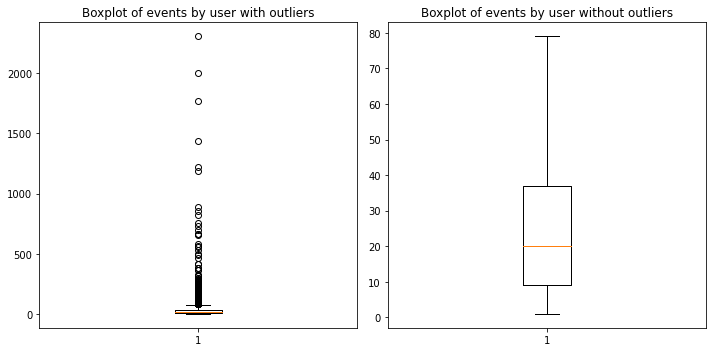

In [77]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].boxplot(events_by_user['event'])
axes[0].set_title('Boxplot of events by user with outliers')
axes[1].boxplot(events_by_user['event'],showfliers=False)
axes[1].set_title('Boxplot of events by user without outliers')
plt.tight_layout()
plt.show()

Upon visualising the above exploration, we can tell that our core dataset sits between 10 and 37 events per users and the average is 32 events per users. Anything above that is considered an outliers. Our main distrupters are considered as users who had more than 80 events records.

### Time Period Analysis

#### Summary

The time period analysis will feature a left-skewed histogram, indicated a concentration of data in the campaign's final weeks. The starting days exhibited low activity, most likely due to preparation, sampling and testing. 

This is why (as briefly touched on in the summary above) we will slice the data from the 1st August to the 7th August, resulting in 1.15% of the data being lost, which won't affect our analysis. Stringent checks detect no implicit or user ID duplicates, applying methods from the "Making Business Decisions" project.

In [78]:
first_date = log_file['timestamp'].min()
last_date = log_file['timestamp'].max()
print("The time period of the date is from",first_date, "to", last_date)

The time period of the date is from 2019-07-25 04:43:36 to 2019-08-07 21:15:17


#### Distribution of all dates

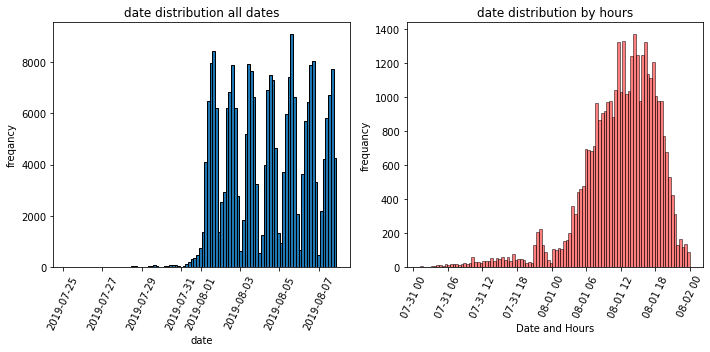

In [79]:
fix, axes = plt.subplots(1,2, figsize=(10,5))

# Distribution by dates
axes[0].hist(log_file['timestamp'], bins=100, edgecolor='black')
axes[0].set_title('date distribution all dates')
axes[0].set_xlabel('date')
axes[0].set_ylabel('freqancy')
axes[0].tick_params(axis='x', labelrotation=65)

# Distribution by day and hour
axes[1].hist(log_file[(log_file['timestamp']>='2019-07-31')&(log_file['timestamp']<='2019-08-02')]['timestamp'], 
         color='red', edgecolor='black', alpha=0.5, bins=100)
axes[1].set_title('date distribution by hours')
axes[1].set_xlabel('Date and Hours')
axes[1].set_ylabel('frequancy')
axes[1].tick_params(axis='x', labelrotation=65)


plt.tight_layout()
plt.show()

#### Values from before 1st August

In [80]:
old_records = log_file[log_file['timestamp'] < '2019-08-01']
missing_values = len(old_records) / len(log_file)*100
print(missing_values)

1.159560630741897


The values before the 1st August made up 1.15% percent of our dataset. Below you will be able to observe the number of events and users during this time.

count    1451.000000
mean        1.947622
std         2.687393
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        39.000000
Name: event, dtype: float64


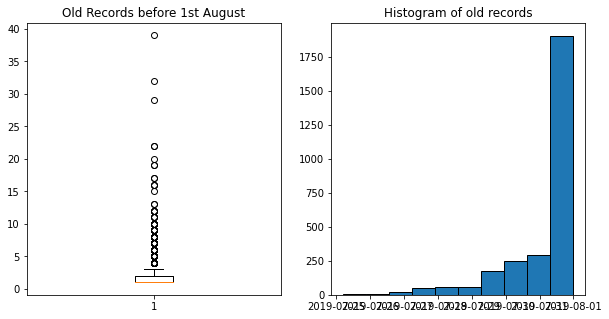

In [81]:
old_users = old_records.groupby('user_id')['event'].count().reset_index()
old_users.columns=['user','event']

fix, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].boxplot(old_users['event'])
axes[0].set_title('Old Records before 1st August')
axes[1].hist(old_records['timestamp'], edgecolor='black')
axes[1].set_title('Histogram of old records')

print(old_users['event'].describe())

plt.show()

When we look at the records before the 1st of August, there was a very low frequancy as we saw in the histograms above, thereforem I have presented a box plot of the old records to show whether there are sufficient records. However, the frequancy is increasing on the 31st July, therefore, it will be worth increasing our data range to include the last day in July and disregard the others.

In [82]:
old_records['event'].value_counts()

MainScreenAppear           1773
OffersScreenAppear          475
CartScreenAppear            365
PaymentScreenSuccessful     200
Tutorial                     13
Name: event, dtype: int64

#### Total Sample Sizes

In [83]:
log_file.groupby('test_id')['user_id'].size()

test_id
246    80181
247    77950
248    85582
Name: user_id, dtype: int64

In [84]:
# Filtering with our new dates
log_fil = log_file[(log_file['timestamp']>='2019-07-31')]
log_fil.groupby('test_id')['user_id'].size()

test_id
246    79922
247    77686
248    85309
Name: user_id, dtype: int64

In [85]:
percent_of_data = len(log_fil) / len(log_file)
print("After filtering by date we are left with {:.2%} in our AB testing dataframe.".format(percent_of_data))

After filtering by date we are left with 99.67% in our AB testing dataframe.


#### Check for implicit duplicate

In [86]:
both_groups = log_file.groupby('user_id').agg({'test_id': 'nunique'}).reset_index()
both_groups.columns = ['user_id', 'test_id']
both_groups = both_groups[both_groups['test_id'] != 1]
duplicate_visitors = both_groups['user_id'].to_list()
print(duplicate_visitors)

[]


Regarding implicit duplicates, which in this case refer to users who may have been placed in different groups, we don't have any, so we can continue with our analysis without this concern.

## Study the event funnel in detail


In [87]:
log_file['test_id'].unique()

array(['246', '248', '247'], dtype=object)

In [88]:
log_file.groupby('event')['user_id'].nunique().sort_values(ascending=False)

event
MainScreenAppear           7439
OffersScreenAppear         4613
CartScreenAppear           3749
PaymentScreenSuccessful    3547
Tutorial                    847
Name: user_id, dtype: int64

In [89]:
log_file.groupby('event')['user_id'].nunique().sort_values(ascending=False)/log_file.user_id.nunique()

event
MainScreenAppear           0.985168
OffersScreenAppear         0.610912
CartScreenAppear           0.496491
PaymentScreenSuccessful    0.469739
Tutorial                   0.112171
Name: user_id, dtype: float64

The above groupby helps us to understand the flow of the product funnel, with the highest proportion of events firing on the home page screen and there being the highest amount of dropoffs at the product page, shopping cart and final purchase.

### Create the funnel tables

We will split up the tests by counting users, events, events per user and then take the percentage dropoffs.
Once, we've creating a table for each test we will append them into one dataframe and create a funnel chart.

In [90]:
test_1 = log_file[log_file['test_id']=='246'].groupby(['test_id','event']).agg({'user_id': ['size','nunique']}).reset_index()
test_2 = log_file[log_file['test_id']=='247'].groupby(['test_id','event']).agg({'user_id': ['size','nunique']}).reset_index()
test_3 = log_file[log_file['test_id']=='248'].groupby(['test_id','event']).agg({'user_id': ['size','nunique']}).reset_index()

In [91]:
test_1.columns = ['test_id','event', 'events', 'users']
test_2.columns = ['test_id','event', 'events', 'users']
test_3.columns = ['test_id','event', 'events', 'users']

In [92]:
test_1 = test_1.sort_values(by='users', ascending=False)
test_2 = test_2.sort_values(by='users', ascending=False)
test_3 = test_3.sort_values(by='users', ascending=False)

In [93]:
test_1['event_per_user'] = test_1['events'] / test_1['users']
test_2['event_per_user'] = test_2['events'] / test_2['users']
test_3['event_per_user'] = test_3['events'] / test_3['users']

In [94]:
test_1

,test_id,event,events,users,event_per_user
1,246,MainScreenAppear,38249,2456,15.573697
2,246,OffersScreenAppear,14904,1545,9.646602
0,246,CartScreenAppear,14798,1270,11.651969
3,246,PaymentScreenSuccessful,11912,1202,9.910150
4,246,Tutorial,318,279,1.139785


In [95]:
test_2

,test_id,event,events,users,event_per_user
1,247,MainScreenAppear,39677,2482,15.985898
2,247,OffersScreenAppear,15341,1530,10.026797
0,247,CartScreenAppear,12548,1240,10.119355
3,247,PaymentScreenSuccessful,10039,1160,8.654310
4,247,Tutorial,345,286,1.206294


In [96]:
test_3

,test_id,event,events,users,event_per_user
1,248,MainScreenAppear,41175,2501,16.463415
2,248,OffersScreenAppear,16563,1538,10.769181
0,248,CartScreenAppear,15322,1239,12.366425
3,248,PaymentScreenSuccessful,12167,1185,10.267511
4,248,Tutorial,355,282,1.258865


In [97]:
test_1['pct_change_users']= test_1['users'].pct_change(periods=1, fill_method=None)
test_2['pct_change_users']= test_2['users'].pct_change(periods=1, fill_method=None)
test_3['pct_change_users']= test_2['users'].pct_change(periods=1, fill_method=None)

#### Drop the Tutorial

The tutorial is not a compulory event. Therefore, does not need to be displayed in the funnel.

In [98]:
test_1 = test_1[test_1['event']!='Tutorial']

In [99]:
test_2 = test_2[test_2['event']!='Tutorial']

In [100]:
test_3 = test_3[test_3['event']!='Tutorial']

In [101]:
test_funnel = pd.concat([test_1, test_2, test_3])

In [102]:
test_funnel

,test_id,event,events,users,event_per_user,pct_change_users
1,246,MainScreenAppear,38249,2456,15.573697,NaN
2,246,OffersScreenAppear,14904,1545,9.646602,-0.370928
0,246,CartScreenAppear,14798,1270,11.651969,-0.177994
3,246,PaymentScreenSuccessful,11912,1202,9.910150,-0.053543
1,247,MainScreenAppear,39677,2482,15.985898,NaN
2,247,OffersScreenAppear,15341,1530,10.026797,-0.383562
0,247,CartScreenAppear,12548,1240,10.119355,-0.189542
3,247,PaymentScreenSuccessful,10039,1160,8.654310,-0.064516
1,248,MainScreenAppear,41175,2501,16.463415,NaN
2,248,OffersScreenAppear,16563,1538,10.769181,-0.383562


In [103]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    y=test_funnel['event'],
    x= test_funnel['users'],
    textinfo ="value+percent initial+percent previous",
    hoverinfo = "percent initial+percent previous",
))
   
fig.update_layout(title="Purchase Funnel Stages with Percentage Dropoff")
fig.show()

#### Conclusion
The above table and visualisation displays the drop offs in users as they go through each stage of the funnel. 

The offer screen had the most dropoffs at the second stage in the funnel, with around 40% of the homepage users staying only across all groups. Following from them a higher proportion of users went through the cart and almost all of the converted at the payment step, which shows positive signs for our campaign profitability.

In [104]:
log_file['user_id'].nunique()

7551

### What share of users make the entire journey from their first event to payment?

In [105]:
# Take the first and final event of the funnel
log_fil[log_fil['event'].isin(['MainScreenAppear','PaymentScreenSuccessful'])].groupby('event')['user_id'].count()

event
MainScreenAppear           118578
PaymentScreenSuccessful     34058
Name: user_id, dtype: int64

Note that the Main screen is the start and the payment screen is the final conversion.

In [106]:
# Let's now find out the number of unique users at each stage by doing the nunique function instead of counting all.
user_journeys = pd.pivot_table(log_fil, index='test_id',columns='event',values='user_id', aggfunc=['nunique'])
user_journeys['completed'] = user_journeys[('nunique','PaymentScreenSuccessful')] / user_journeys[('nunique','MainScreenAppear')]
user_journeys

nunique                                      \
event   CartScreenAppear MainScreenAppear OffersScreenAppear   
test_id                                                        
246                 1267             2452               1544   
247                 1239             2479               1526   
248                 1236             2498               1536   

                                         completed  
event   PaymentScreenSuccessful Tutorial            
test_id                                             
246                        1200      278  0.489396  
247                        1159      285  0.467527  
248                        1183      282  0.473579

#### Conclusion/Summary

- There were 49% of the users who completed the course from the first event for test from 246.
- There was a -3% difference for group 247 with 46% proporotion of users completing the event funnel from step 1.
- There was a 1% difference between 246 and 248 as there was a 47% proportion of users completing the event funnel form step 1.

### How long did it take from MainScreenAppear to PaymentScreenSuccessful?

We will now determine how long it took the user to purchase to purchase. We'll first need to take out the tutorial step as this appears to be optional and could constitute a video on the final step or the homepage. 

Then we will calculate the first date for each event and calculate the difference between each of the two key steps Main Screen and Purchase Screen.

In [107]:
# Take all of the first timestamps for each of the events.
first_timestamp = pd.pivot_table(log_fil[log_fil['event'] != 'Tutorial'], 
                                 index='user_id', columns='event', values='timestamp', aggfunc='min').reset_index()
first_timestamp.head(5)

event,user_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
0,6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT
1,6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
2,6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
3,7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT
4,7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45


In [108]:
time_elapsed = (first_timestamp['PaymentScreenSuccessful'] - first_timestamp['OffersScreenAppear'])
time_elapsed.sort_values().head(5)

973    -6 days +01:12:57
6590   -6 days +10:19:16
5477   -6 days +17:44:10
159    -6 days +22:49:35
4035   -5 days +00:13:25
dtype: timedelta64[ns]

In [109]:
# Now add the time elapsed to a column
first_timestamp['time_elapsed'] = (first_timestamp['PaymentScreenSuccessful'] - first_timestamp['OffersScreenAppear'])

In [110]:
# Create a numerical columns for the data
first_timestamp['time_elapsed'] = first_timestamp['time_elapsed'].dt.days

In [111]:
first_timestamp[first_timestamp['time_elapsed'] < 0]

event,user_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,time_elapsed
1,6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,-1.0
2,6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,-1.0
16,28534696657485531,2019-08-01 18:27:59,2019-08-01 18:27:53,2019-08-01 18:28:09,2019-08-01 18:27:58,-1.0
19,31467376676344061,2019-08-01 09:51:05,2019-08-01 09:51:03,2019-08-01 09:51:36,2019-08-01 09:51:05,-1.0
27,34565258828294726,2019-08-02 18:21:44,2019-08-02 17:01:18,2019-08-02 18:21:46,2019-08-02 18:21:44,-1.0
...,...,...,...,...,...,...
7515,9198403615978777375,2019-08-01 14:25:34,2019-08-01 07:54:53,2019-08-01 14:25:50,2019-08-01 14:25:34,-1.0
7517,9202147366649120172,2019-08-02 18:53:11,2019-08-02 18:53:06,2019-08-02 18:53:20,2019-08-02 18:53:11,-1.0
7524,9211196294399965012,2019-08-03 08:47:24,2019-08-03 08:47:18,2019-08-03 08:47:33,2019-08-03 08:47:23,-1.0
7532,9216369613838971606,2019-08-02 12:05:54,2019-07-31 12:15:48,2019-08-02 12:06:12,2019-08-02 12:05:54,-1.0


In [112]:
first_timestamp[first_timestamp['user_id'] == 76430713684339660]

event,user_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,time_elapsed
56,76430713684339660,2019-07-31 12:19:59,2019-08-02 11:13:18,2019-08-03 07:12:45,2019-07-31 12:19:59,-3.0


The negative times could be due to users who visited the main screen after they visited the payment screen due to openning in a new tab, or being on the payment screen for a long period of time. Therefore, we will remove the negative values from the table.

In [113]:
negative_times = first_timestamp[first_timestamp['time_elapsed'] < 0]
first_timestamp.drop(negative_times.index, inplace=True)
first_timestamp['time_elapsed'].sort_values()

3862    0.0
4703    0.0
4691    0.0
4689    0.0
4685    0.0
       ... 
7530    NaN
7531    NaN
7535    NaN
7536    NaN
7537    NaN
Name: time_elapsed, Length: 6210, dtype: float64

In [114]:
first_timestamp['time_elapsed'].describe()

count    2207.000000
mean        0.540100
std         1.096066
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         7.000000
Name: time_elapsed, dtype: float64

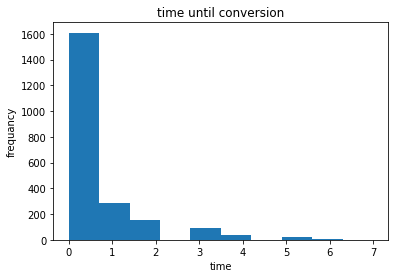

In [115]:
# See the distribution from the pivot table.
plt.hist(first_timestamp['time_elapsed'], bins=10)
plt.title('time until conversion')
plt.xlabel('time')
plt.ylabel('frequancy')
plt.show()

The majority of our users took less than a day to complete a purchase with a small variety of users taking up to a full day before making a purchase on the website.

## Study the results of the experiment (A/A1, A/B, A1/B, AA1/B)

We will now perform a series of satistical tests to determine which group outperformed which.

We will be testing the statistical significance between the test group (248: with new fonts) and both of our control (as we now know there will be no difference between the test.)

Here we will conduct 4 tests:

- 246 vs 247 (control groups A/A1)
- 246 vs 248 (A/B)
- 247 vs 248 (A1/B)
- 246+247 vs 248 (AA1/)

For the test, we will look at the following hypothesis, for each event and test group:

- H0: There was no statistical difference between the two groups
- H1: There was a clear difference between the events of the groups

### Take the unique users per test group
- Firstly, let's take thew unique users from our three different groups.
- I will use test_id as the index and do a nunique.
- This will give us our trials which we will call in our z_test function below.

In [116]:
nu_user_id = log_fil.groupby('test_id').agg({'user_id':'nunique'}).reset_index()
nu_user_id

,test_id,user_id
0,246,2485
1,247,2517
2,248,2540


### Take the unique users as they pass through the funnel
- The below pivot table gives us the unique users per event. 
- This gives us our successes that we will call into the function below.

In [117]:
funnel=(log_fil.pivot_table(index='event', columns='test_id', values='user_id', aggfunc='nunique')
        .reset_index()
        .query('event !="Tutorial"'))
funnel['total'] = funnel['246']+funnel['247']+funnel['248']
funnel=funnel.sort_values(by='total', ascending=False)
funnel

test_id,event,246,247,248,total
1,MainScreenAppear,2452,2479,2498,7429
2,OffersScreenAppear,1544,1526,1536,4606
0,CartScreenAppear,1267,1239,1236,3742
3,PaymentScreenSuccessful,1200,1159,1183,3542


### Z Test Function

<b>Step 1</b>
- We add the parameters: trials (total unique users per group), column1 (represents the first test group from the successes pivot) and column2 (repesents the second column from the successes pivot)

<b>The Loop:</b>
- We loop over the each event and take the values for based on our chosen test groups.
- then we will calculate the proportions of successes to trials for both test groups.

<b>Step 3:</b>
- We print here the values for each event from the pivot alongside the unique users.

<b>Step 4:</b>

Combined data: 
- The next step is to sum up both trials and successes and take the proportion.

Statistical test:
- Differences tells us how much the groups differ from each other (p1 - p2), Taking the difference between the proportions
- p_compinbed helps us to measure the variability in the data
- Calculate the Z Value tells us how many standard deviations the difference between the groups is from what you would expect. Then when we print the results, if the z_value is larg than there is a statisical significance.

Output:
- We will then print whether or not the pvalue is less than the alpha and whether we reject the null hypothesis or not.

In [118]:
import scipy.stats as stats
def z_test(array, trials, column1, column2):
    for i in range(0, 4):
        successes = np.array([array.loc[i, column1], array.loc[i, column2]])        
        p1 = successes[0]/trials[0]        
        p2 = successes[1]/trials[1]
        
        # 
        print(successes[0], successes[1],trials[0], trials[1])
        
        # The next step is to sum up and take the proportion from all groups
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])       
        difference = p1 - p2     
        # Assess the statisticual significance using the z_value statistical function
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))       
        distr = stats.norm(0, 1)        
        p_value = (1 - distr.cdf(abs(z_value))) * 2   
        alpha = 0.05 
        print('{} p-value: {}'.format(funnel['event'][i], p_value))
        if p_value < alpha:
            print('We reject the null hypothesis: There was a clear difference between the successful events of the groups')
        else:
            print('There was no statistical difference between the success rate of the two groups')
        print('')

### Statistical Test Results

#### A/A1 test - The control groups

From the results below, we know that the main screen was the most popular event and the statistical significance between the groups accross all the events was insignificant. This was exactly what the product and marketing expected, which shows that both groups are suitable for comparision against our test group where the team adjusted the fonts.

In [119]:
# The control group test.#А/А1
trials = np.array([nu_user_id.loc[0, 'user_id'], nu_user_id.loc[1, 'user_id']])
z_test(funnel, trials, '246','247')

1267 1239 2485 2517
CartScreenAppear p-value: 0.21306131796590932
There was no statistical difference between the success rate of the two groups

2452 2479 2485 2517
MainScreenAppear p-value: 0.5868776836512959
There was no statistical difference between the success rate of the two groups

1544 1526 2485 2517
OffersScreenAppear p-value: 0.2743505991932964
There was no statistical difference between the success rate of the two groups

1200 1159 2485 2517
PaymentScreenSuccessful p-value: 0.11210845100173072
There was no statistical difference between the success rate of the two groups



#### The A/B (control group 1 vs. test group)

From the results below, we can see that there was know significant difference between 3 out of 4 events, which the home page having more events. Therefore, suggesting that for the test group there were slightly more visitors entering the website.

In [120]:
# The control group 2 against the altered fonts test. (A/B)
trials = np.array([nu_user_id.loc[0, 'user_id'], nu_user_id.loc[1, 'user_id']])
z_test(funnel, trials, '246', '248')

1267 1236 2485 2517
CartScreenAppear p-value: 0.1836882061117231
There was no statistical difference between the success rate of the two groups

2452 2498 2485 2517
MainScreenAppear p-value: 0.04571267773459464
We reject the null hypothesis: There was a clear difference between the successful events of the groups

1544 1536 2485 2517
OffersScreenAppear p-value: 0.4206301970781001
There was no statistical difference between the success rate of the two groups

1200 1183 2485 2517
PaymentScreenSuccessful p-value: 0.36130452637373667
There was no statistical difference between the success rate of the two groups



#### The A1/B test (control group 2 vs. test group) 

Like the above results, we can also see that there was a statistical significance between the events fired on the homepage for the test group than the control groups, which resulted in their being a statistical significance for these events. Therefore, it could have been that the marketing campaigns teams increased the budget or changed their optimisation for test group.

In [121]:
# Looking at the results of the control group 247 and group 248.
trials = np.array([nu_user_id.loc[0, 'user_id'], nu_user_id.loc[1, 'user_id']])
z_test(funnel, trials, '247','248')

1239 1236 2485 2517
CartScreenAppear p-value: 0.5942899339015177
There was no statistical difference between the success rate of the two groups

2479 2498 2485 2517
MainScreenAppear p-value: 0.01003830260426053
We reject the null hypothesis: There was a clear difference between the successful events of the groups

1526 1536 2485 2517
OffersScreenAppear p-value: 0.7808136650520889
There was no statistical difference between the success rate of the two groups

1159 1183 2485 2517
PaymentScreenSuccessful p-value: 0.7983247062909817
There was no statistical difference between the success rate of the two groups



#### AA1/B test: Statistical significance between both groups and the test group

Despite, what we said above, when we combined both control groups for the AA1/B test, there is no statistical significance between the test group and control groups. Therefore, we can say that there was no bias between the campaign optimisation for each group.

In [122]:
trials_a_aa1 = np.array([nu_user_id.loc[0, 'user_id'] + nu_user_id.loc[1, 'user_id'], nu_user_id.loc[2, 'user_id']])
funnel['AA1'] = funnel['246'] + funnel['247']
z_test(funnel, trials_a_aa1, 'AA1', '248')

2506 1236 5002 2540
CartScreenAppear p-value: 0.23764471031415635
There was no statistical difference between the success rate of the two groups

4931 2498 5002 2540
MainScreenAppear p-value: 0.42897263461182167
There was no statistical difference between the success rate of the two groups

3070 1536 5002 2540
OffersScreenAppear p-value: 0.4471809415681398
There was no statistical difference between the success rate of the two groups

2359 1183 5002 2540
PaymentScreenSuccessful p-value: 0.629668311887492
There was no statistical difference between the success rate of the two groups



## Conclusion and Business Recommendations

### Conclusion

- Firstly, we filtered our core dataset to cut out the campaign dates where the IT and Development teams were testings the application (after 31st July, when traffic started). These only turned into a 1% loss of data so it will have no affect on our analysis.
- Our outliers in the data, showed users interactiving and exceeding over 80 events. Suggesting that there was a high bounce rate and not enough users completion meaningful actions on the website. 
- The core data was without outliers was users with 10 to 37 events
- There were no duplicates, problems with missing values and no implicit duplicates (users in more than one group)
- There was no statistical significance between the control groups and this is what we had expected to see to ensure there is no bias
- There was also only a statistical significance between the ho0me page events in both the control groups and the test group. Possibly due to an increased number of visitors to the new test group.

When we compare the funnel, we noticed that there was a:
- There were 49% of the users who completed the course from the first event for test from 246.
- There was a -3% difference for group 247 with 46% proporotion of users completing the event funnel from step 1.
- There was a 1% difference between 246 and 248 as there was a 47% proportion of users completing the event funnel form step 1.

The conversion rate for each test group was stable and the majority of the users who visiting the product offering went to the cart page and continued to purchase. 90% of the users went from the cart to complete the payment, meaning that there was a cart abandonment rate of 10%.


### Business Recommendations

- We need to focus on optimising our user engagement to ensure there's no more than 10-37 events committed during a session.
- Focus on improving the calls to action on the home page to drive more traffic to product offerings.
- There is no need to consider font changes as they don't impact user behavior enough to warrant the hours of work.
- Making too many drastic changes may damage the user experience and reduce our online success rate.